In [1]:
import scanpy as sc
import pandas as pd
import numpy as np 
import seaborn as sn
from scipy.stats import binom
from matplotlib import rcParams
import matplotlib.pyplot as plt

# Read in adata

In [10]:
file_list = ['/data/aneuploidy/cat_crop/' + x + '/filtered_feature_bc_matrix.h5' for x in ['A','B','C','D','E','F']]
adata_list = [sc.read_10x_h5(file, gex_only=False) for file in file_list]

/home/ssm-user/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ssm-user/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ssm-user/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ssm-user/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ssm-user/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique.

In [11]:
[adata.var_names_make_unique() for adata in adata_list]

[None, None, None, None, None, None]

In [12]:
adata = adata_list[0].concatenate(adata_list[1:])

/home/ssm-user/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [13]:
adata

AnnData object with n_obs × n_vars = 206976 × 37001
    obs: 'batch'
    var: 'gene_ids', 'feature_types', 'genome'

# Read guide data 

In [14]:
file_list = ['/data/aneuploidy/cat_crop/' + x + '/protospacer_calls_per_cell.csv' for x in ['A','B','C','D','E','F']]
guides_list = [pd.read_csv(file) for file in file_list]

In [15]:
for batch, guides in enumerate(guides_list):
    guides['cell_barcode'] = guides['cell_barcode'] + "-" + str(batch)

In [16]:
guides = pd.concat(guides_list)
adata.obs['aggr_barcode'] = adata.obs.index
guides.columns = ["aggr_barcode"] + list(guides.columns[1:])

In [17]:
guideMeta = pd.merge(adata.obs, guides, on = 'aggr_barcode', how = 'left')
guideMeta.index = guideMeta['aggr_barcode']
adata.obs = guideMeta

In [18]:
# remove cells with no guide calls whatsoever
adata = adata[~adata.obs['num_umis'].isnull(),:]

In [19]:
adata

View of AnnData object with n_obs × n_vars = 204374 × 37001
    obs: 'batch', 'aggr_barcode', 'num_features', 'feature_call', 'num_umis'
    var: 'gene_ids', 'feature_types', 'genome'

# Processing guide data

In [20]:
listUmi = []
umiCountsFirstMax = []
umiCountsSecMax = []
for umi in adata.obs['num_umis']:
    umiList = [int(x) for x in umi.split('|')]
    listUmi.append(umiList)
    umiList.sort()
    firstMax = len(umiList) - 1
    secondMax = firstMax - 1
#     print(umiList)
    umiCountsFirstMax.append(umiList[firstMax])
    umiCountsSecMax.append(umiList[secondMax])

In [21]:
listUmi = []
for umi in adata.obs['num_umis']:
    umiList = [int(x) for x in umi.split('|')]
    listUmi.append(umiList)
adata.obs['umiList'] = listUmi

/tmp/ipykernel_1690098/3074645891.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['umiList'] = listUmi


In [22]:
featureList = []
for feature in adata.obs['feature_call']:
    features = [str(x) for x in feature.split('|')]
    featureList.append(features)
adata.obs['featureList'] = featureList

In [23]:
adata.obs['maxUmi1'] = umiCountsFirstMax
adata.obs['maxUmi2'] = umiCountsSecMax

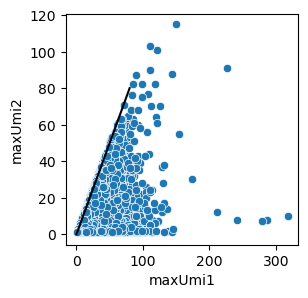

In [24]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(3,3))
sn.scatterplot(data = adata.obs, x = 'maxUmi1', y = 'maxUmi2', ax = ax)
ax.plot([0, 80], [0, 80], color = 'k')

In [25]:
adata.obs['cell_barcode'] = adata.obs['aggr_barcode'].str.slice(0,18)

# Assigning Guides using a binomial distribution

In [26]:
guidePvalue = []
p = 0.5 # null hypothesis that the probability of selecting either guide is 50/50
for i in adata.obs.index:
    n = adata.obs.loc[i, 'maxUmi1'] + adata.obs.loc[i, 'maxUmi2']
    pval = binom.sf(adata.obs.loc[i, 'maxUmi1'] - 1, n, p) # binomial distribution
    guidePvalue.append(pval)
    
# Assign new column
adata.obs['guidePvalue'] = guidePvalue
# assign single or multiple guide based off of pvalue
adata.obs['pvalueAssign'] = adata.obs['guidePvalue'].apply(lambda x: 'SingleGuide' if x <= 0.1 else 'MultipleGuide')

# Assign guides
guides = []
for i in adata.obs.index:
    if adata.obs.loc[i, 'pvalueAssign'] == 'SingleGuide':
        maxUmiIdx = max(adata.obs.loc[i, 'maxUmi1'],adata.obs.loc[i, 'maxUmi2'])
        featureIdx = adata.obs.loc[i, 'umiList'].index(maxUmiIdx)
#         featureIdx = adata.obs.loc[i, 'umiList'].index(umiIdx)
        guides.append(adata.obs.loc[i, 'featureList'][featureIdx])
    else:
        guides.append('Multiple Guides')

adata.obs['guides'] = guides

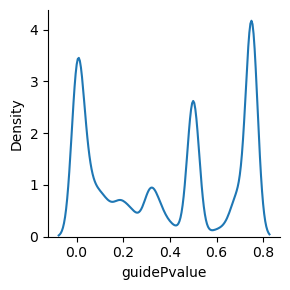

In [27]:
sn.displot(adata.obs['guidePvalue'], kind = 'kde', height=3, aspect=3/3)

In [28]:
adata.obs['pvalueAssign'].value_counts()

MultipleGuide    144526
SingleGuide       59848
Name: pvalueAssign, dtype: int64

In [29]:
adata.obs = adata.obs.drop('umiList', axis = 1)

In [30]:
adata.obs = adata.obs.drop('featureList', axis = 1)

In [31]:
adata.obs['guides'].value_counts()

Multiple Guides    144526
ADA2-1               2029
HBB-2                1958
USP22-1              1933
HBB-3                1743
                    ...  
CIITA-4                 5
HTT-1                   5
IL2RB-3                 4
PIK3CD-1                4
ERCC8-3                 2
Name: guides, Length: 401, dtype: int64

# Add multi-seq outputs to adata

In [33]:
def get_multi_output(x, batch):
    if not pd.isna(x['multi_output']):
        return x['multi_output']
    if x['batch'] != batch:
        return np.NaN
    try:
        return multi_dict[x['cell_barcode']]    
    except KeyError:
        return np.NaN

In [36]:
adata.obs['multi_output'] = np.NaN
for i in range(6):
    multi = pd.read_csv("/data/aneuploidy/cat_crop/multi_outs/sample" + str(i + 1) + "/assignment_confidence_table.csv", index_col = "Row")
    multi_dict = dict(zip(multi['Barcode'], multi['Assignment']))
    adata.obs['multi_output'] = adata.obs.apply(get_multi_output, axis = 1, args = (str(i),))
    print(f'Processed sample {i + 1}/6')

Processed sample 1/6
Processed sample 2/6
Processed sample 3/6
Processed sample 4/6
Processed sample 5/6
Processed sample 6/6


# Calculate qc metrics

In [38]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [39]:
adata.write("fully_processed.h5ad")